In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# 🧹 Data cleaning 

1. Give repeated words unique labels (the, the-2, the-3, etc)

In [55]:
def unique_word_labels(data):
    word_count = {}
    last_word = None
    unique_data = []

    for index, row in data.iterrows():
        word = row['word']
        
        # Check if this is a repeated word
        if word == last_word:
            # Use the same label as the previous occurrence if it's in a clump
            unique_word = unique_data[-1]['word']
        else:
            # If it's a new occurrence or a different word
            count = word_count.get(word, 0) + 1
            word_count[word] = count

            if count == 1:
                unique_word = word  # First occurrence remains the same
            else:
                unique_word = f"{word}-{count}"  # Label subsequent occurrences uniquely

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        last_word = word  # Update the last seen word
    return pd.DataFrame(unique_data)

2. Normalize pitches to a standard key

In [50]:
standard_key = 'C'

def half_steps_between(original_key, transpose_key):
    keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A"]
    original_key_index = keys.index(original_key)
    transpose_key_index = keys.index(transpose_key)
    return transpose_key_index - original_key_index

def transpose(original_hz, original_key, transpose_key, octave, id):
    steps_to_transpose = half_steps_between(original_key, transpose_key)
    new_frequency = original_hz * (2 ** (steps_to_transpose / 12))
    octave_shift = 0 if pd.isna(octave) else octave
    new_frequency *= (2 ** octave_shift)
    return new_frequency

def normalize_pitch(pitch_data, id, key, octave):
    normalized = []
    for index, row in pitch_data.iterrows():
        new_row = {col: row[col] for col in pitch_data.columns}
        new_row['frequency'] = transpose(row['frequency'], key, standard_key, octave, id)
        normalized.append(new_row)
    return pd.DataFrame(normalized)

3. Filter out frequencies < 100

In [4]:
def filter_frequencies(data):
    return data[data['frequency'] >= 100]

### Run this to clean all performances.

In [51]:
def get_data(id, key, octave):
    print(id, key)
    words = pd.DataFrame(pd.read_csv('words/' + id + '.csv'))
    pitch = pd.DataFrame(pd.read_csv('pitch/' + id + '.csv'))
    
    wordsCleaned = unique_word_labels(words)
    pitchCleaned = normalize_pitch(filter_frequencies(pitch), id, key, octave)
    
    return {
        'words_data': wordsCleaned,
        'pitch_data': pitchCleaned
    }

performances_raw = pd.DataFrame(pd.read_csv('performances.csv'))

performances = {row['id']: get_data(row['id'], row['key'], row['octave']) for index, row in performances_raw.iterrows()}

print(str(len(performances)) + ' performances cleaned and ready.')

michelle D
jazmine F
demi G#
carrie F#
harry G#
5 performances cleaned and ready.


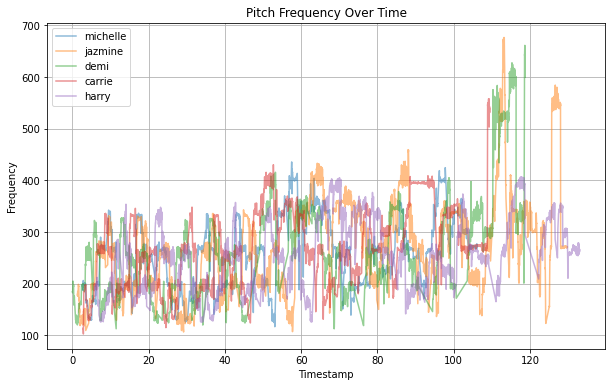

In [54]:
def plot_pitch(performances):
    plt.figure(figsize=(10, 6))

    for performer, data in performances.items():
        pitch_df = pd.DataFrame(data['pitch_data'])
        plt.plot(pitch_df['timestamp'], pitch_df['frequency'], label=performer, alpha=0.5)

    plt.title('Pitch Frequency Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pitch(performances)

# 🎤 DIVA 

## D = Density

Total notes in the performance compared to the standard performance.

In [76]:
def density(id):
    standard = performances['michelle']
    standard_length = len(standard['words_data'])
    length = len(performances[id]['words_data'])
    return ((length - standard_length) / standard_length)*100

41.007194244604314


In [81]:
# The top 5 by DENSITY
n = 3
density_dict = {performer: density(performer) for performer, data in performances.items()}
sorted_density = sorted(density_dict.items(), key=lambda x: x[1], reverse=True)
for performer, density_value in sorted_density:
    print(f"{performer}: {density_value}")

jazmine: 97.84172661870504
demi: 58.992805755395686
carrie: 41.007194244604314
harry: 35.25179856115108
michelle: 0.0


## I = Interpretation

Comparing the pitch curve to the standard curve using DTW.